Imports

In [209]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

In [210]:
from Model.Network import Network
from Layers.MaxPooling import MaxPooling
from Layers.FullyConnected import FullyConnected
from Layers.Convolution import Convolution
from Loss.CrossEntropyLossFunction import CrossEntropyLossFunction
from Activation.Softmax import Softmax
from Layers.Flatten import Flatten
from Activation.ReLU import ReLU

Preprocess Images

In [211]:
image_shape = (64, 64)

Extract Data

In [212]:
# Sort the folders in the dataset in alphabetical order

classes = sorted(os.listdir('../asl_dataset'))

In [213]:
images = []
labels = []

# Extract the images and labels of each subdirectory in the dataset
for folder in classes:
    folder_dir = os.path.join('../asl_dataset', folder)

    for image in os.listdir(folder_dir):
        img_path = os.path.join(folder_dir, image)

        data_sample = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        data_sample = cv2.resize(data_sample, image_shape)
        data_sample = data_sample / 255.0

        images.append(data_sample)
        labels.append(folder)

Preprocess the Data

In [214]:
# Reshape the images to create the x_data

x_data = np.array(images).reshape(-1, 1, image_shape[0], image_shape[1])

In [215]:
# One-hot-encode the labels using pandas to create the y_data

df = pd.DataFrame(labels)
df = pd.get_dummies(df)

y_data = df.values

In [216]:
# Split the data in training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

Create and Train the Model

In [217]:
# Define the loss function and network layers for both image sizes

loss_function = CrossEntropyLossFunction()

network_layers_28 = [
    # Input (Image Shape): 1 (Grayscale Channel) * 28 * 28. Convolution using a kernel of size 3 to create an output with depth 8. Output: 8 * 26 * 26.
    Convolution(input_shape=(1, 28, 28), output_depth=8, kernel_size=3),
    ReLU(),
    # Max Pooling will divide shape by the stride. Output of Max Pooling: 8 * 13 * 13.
    MaxPooling(pool_size=2, stride=2),
    
    # Input: 8 * 13 * 13. Often, each Convolution Layer doubles the output_depth. Output: 16 * 11 * 11
    Convolution(input_shape=(8, 13, 13), output_depth=16, kernel_size=3),
    ReLU(),
    # Output: 16 * 5 * 5.
    MaxPooling(pool_size=2, stride=2),
    
    # Flattening multidimensional array to 1D. Input: 16 * 5 * 5.
    Flatten(),

    FullyConnected(input_size=16 * 5 * 5, output_size=128),
    ReLU(),
    
    # Input: 128. Output: 36 (Number of total labels).
    FullyConnected(input_size=128, output_size=y_data.shape[1]),
    Softmax()
]

network_layers_64 = [
    # Input (Image Shape): 1 (Grayscale Channel) * 64 * 64. Convolution using a kernel of size 3 to create an output with depth 16. Output: 16 * 62 * 62.
    Convolution(input_shape=(1, 64, 64), output_depth=16, kernel_size=3),
    ReLU(),
    # Max Pooling will divide shape by the stride. Output of Max Pooling: 16 * 31 * 31.
    MaxPooling(pool_size=2, stride=2),
    
    # Input: 16 * 31 * 31. Often, each Convolution Layer doubles the output_depth. Output: 32 * 29 * 29
    Convolution(input_shape=(16, 31, 31), output_depth=32, kernel_size=3),
    ReLU(),
    # Output: 32 * 14 * 14.
    MaxPooling(pool_size=2, stride=2),

    # Input: 32 * 14 * 14. Output: 64 * 12 * 12.
    Convolution(input_shape=(32, 14, 14), output_depth=64, kernel_size=3),
    ReLU(),
    # Output: 64 * 6 * 6.
    MaxPooling(pool_size=2, stride=2),

    # Flattening multidimensional array to 1D. Input: 64 * 6 * 6.
    Flatten(),
    
    FullyConnected(input_size=64 * 6 * 6, output_size=256),
    ReLU(),
    
    # Input: 256. Output: 36 (Number of total labels).
    FullyConnected(input_size=256, output_size=y_data.shape[1]),
    Softmax()
]

In [220]:
ASL_model = Network(network_layers_64, loss_function)

In [221]:
ASL_model.train(x_train, y_train, 20, 0.01)

Save and Retrieve the Model

In [222]:
import pickle

"""Save the trained model's weights and biases in a pickle (.pkl) file."""
def save_model(model, model_path):
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

"""Load the model from the pickle file."""
def get_model(model_path):
    with open(model_path, 'rb') as model:
        CNN = pickle.load(model)

    return CNN

In [223]:
save_path = '../ASL_trained_CNN64x64.pkl'
save_model(ASL_model, save_path)

Predict and Evaluate

In [224]:
"""Gets true and predicted labels for a given image."""
def get_labels(image, index, CNN):
    label = np.argmax(y_test[index])
    prediction = CNN.predict(image)
    pred_label = np.argmax(prediction)
    
    return label, pred_label

In [225]:
"""Use the trained CNN to predict on a random image in the testing set."""
def predict(CNN):
    rand_index = np.random.randint(0, len(x_test) - 1)
    image = x_test[rand_index]
    
    label, pred_label = get_labels(image, rand_index, CNN)

    print("True Label: ", classes[label])
    print("Predicted Label: ", classes[pred_label])

    plt.imshow(image[0], cmap='gray')
    plt.show()

In [226]:
"""Evaluate the percent accuracy of the trained CNN against the testing set."""
def accuracy(CNN):
    cnt = 0

    for i in range(len(x_test)):
        image = x_test[i]
        label, pred_label = get_labels(image, i, CNN)

        if pred_label == label:
            cnt += 1

    return (cnt / len(x_test)) * 100

Evaluate 28x28 Image With 20 Epochs

True Label:  s
Predicted Label:  s


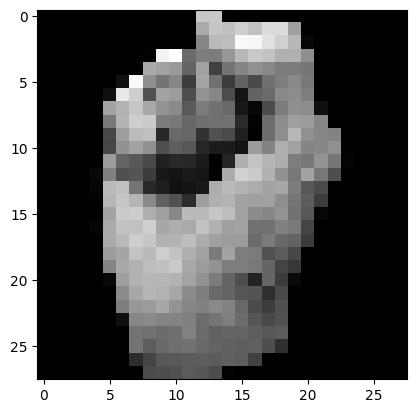

Accuracy of CNN with 28x28 Image and 20 Epochs:  88.07157057654076


In [196]:
model_path = '../ASL_trained_CNN28x28.pkl'

CNN_model_28 = get_model(model_path)
predict(CNN_model_28)
print("Accuracy of CNN with 28x28 Image and 20 Epochs: ", accuracy(CNN_model_28))

Evaluate 64x64 Image With 20 Epochs

True Label:  9
Predicted Label:  9


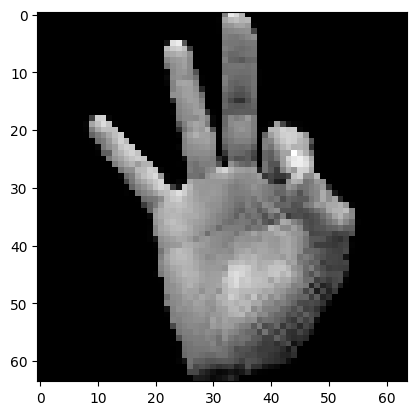

Accuracy of CNN with 28x28 Image and 20 Epochs:  93.43936381709742


In [229]:
model_path = '../ASL_trained_CNN64x64.pkl'

CNN_model_64 = get_model(model_path)
predict(CNN_model_64)
print("Accuracy of CNN with 28x28 Image and 20 Epochs: ", accuracy(CNN_model_64))